# Constraint Analysis

* This notebooks shows you how to create a constraint analysis diagram. The numbers here are rough estimates. You should further refine and verify these numbers with your team. You may wish to add additional constraints, or remove existing constraints, to represent the reuqirements in the RFP.

## Definitions
* Thrust to Weight Ratio: Sea-level static thrust/ Maximum takeoff weight
* Wing Loading: Maximum takeoff weight / wing area

## Why use Casadi?
* Automatic differentiation (computes gradients for you)
* Overkill for this application, but can be used in later stages of your design cycle when optimizations get more complex

In [23]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)  # makes figures larger by default

### Master Equation for Jet

See Mattingly Chapter 2, and Loftin Chapter 7.

$$\frac{T}{W} = \frac{\beta}{\alpha} \left\{
    \frac{q}{\beta}\left[
        \frac{C_{D_0} + C_{D_C}}{W/S} + \frac{1}{\pi AR e} \left(\frac{n \beta}{q}\right)^2 \frac{W}{S}
    \right]
    + \frac{1}{V} \frac{dh}{dt} + \frac{1}{g} \frac{dV}{dt}
    \right\}$$

In [24]:
def atmosphere(h):
    # http://fisicaatmo.at.fcen.uba.ar/practicas/ISAweb.pdf
    # https://www.engineeringtoolbox.com/elevation-speed-sound-air-d_1534.html
    p0 = 101325
    rho0 = 1.225
    T0 = 288.15
    a0 = 340.294
    g0 = 9.80665
    R = 287.04
    
    p11 = 22632
    T11 = 216.65
    h11 = 11000
    
    if h < 11000: # troposphere
        T = T0 - 6.5*h/1000
        p = p0*(1 - 0.0065*h/T0)**5.2561
    elif h < 25000:  # lower stratosphere
        T = T11
        p = p11*np.exp(-g0*(h - h11)/(R*T11))
    else:
        raise ValueError('invalid altitude: ', h)
    rho = p/(R*T)
    gamma = 1.4
    a = np.sqrt(gamma*R*T)
    return {
        'T': T,
        'a': a,
        'p': p,
        'rho': rho
    }

In [3]:
atmosphere(10000)

{'T': 223.14999999999998,
 'a': 299.45645159188,
 'p': 26434.754590986628,
 'rho': 0.41270142687806777}

In [25]:
def T_W_cruise(W_S):
    # cruise flight, master equation
    h = 12500  # altitutde
    atmos_data = atmosphere(h)
    V = 0.7*atmos_data['a'] # cruise velocity (0.7 Mach), [m/s]
    rho = atmos_data['rho'] # air density, [kg/m^3]
    beta = 1  # weight fraction (current weight/gross weight), []
    
    AR = 9  # aspect ratio, []
    g = 9.8 # accel of gravity, [m/s^2]
    q = 0.5*rho*V**2  # dynamic pressure at cruise
    alpha = 0.3 # engine lapse rate (thrust/ thrust sea level), []
    e = 0.7 # oswald efficiency factor
    V_climb = 0 # climb rate, [m/s]
    n = 1 # load_factor (L/W), 1 when in steady level flight, >1 when turning, []
    CD0 = 0.02 # Parasite Drag Coefficient, []
    CDC = 0  # Compressibility Drag Coefficient, []
    accel = 0  # acceleration, [m/s^2]
    pi = np.pi # constants from numpy

    # required thrust to weight
    return (beta/alpha)*(
        (q/beta)*(
            (CD0 + CDC)/W_S
            + (1/(pi*AR*e))*(n*beta/q)**2*(W_S)
        )
        + (1/V)*V_climb + (1/g)*accel
    )

## Takeoff Distance for V/STOL

From Kohlman, page 83
$$ S_g = \left[\dfrac{W}{\sigma S C_{L_{TO}}} \right] \frac{1}{\frac{T}{W}} \dfrac{1}{g \rho_0}$$

This can be rearranged to:
$$ \dfrac{T}{W} = \left[\dfrac{\frac{W}{S}}{\sigma C_{L_{TO}}} \right]  \dfrac{1}{S_g g \rho_0}$$

In [26]:
def T_W_takeoff_distance(W_S):
    # stol jet takeoff, non-vectored thrust
    # kohlman, pg. 83
    CL_TO = 1.8  # lift coefficient at take-off, []
    rho = 1.225  # air density at sea level, [kg/m^3]
    sigma = 1  # Area_exit / Area_rotor, []
    Sg_min = 305  # minimum takeoff distance, [m], STOL definition https://en.wikipedia.org/wiki/STOL
    g = 9.8 # accel of gravity, [m/s^2]
    # reqtured thrust to weight
    return (W_S/(sigma*CL_TO))*(1/(Sg_min*g*rho))

## Takeoff Distance for V/STOL with Thrust Vectoring

$$ S_{g\theta} = S_g \sqrt{1 - (T/W)^2} $$

Where $S_{g\theta}$ is the takeoff distance when optimally thrust vectoring, and $S_g$ is the takeoff distance without thrust vectoring.

In [6]:
import sympy
theta = sympy.symbols('theta')
T_W = sympy.symbols('\\frac{T}{W}')
W_S = sympy.symbols('\\frac{W}{S}')
S_g = sympy.symbols('S_g')
S_go = sympy.symbols('S_{go}')

CL_TO = sympy.symbols('CL_{TO}')
g = sympy.symbols('g')
sigma = sympy.symbols('sigma')
rho_0 = sympy.symbols('rho_0')

eq1 = S_go - S_g*sympy.sqrt(1 - T_W**2)  # optimal thrust vectoring angle
eq2 = S_g - W_S/(sigma*CL_TO*g*rho_0*T_W)
S_go_sol = sympy.solve([eq1, eq2], [S_g, T_W], dict=True)[0][T_W]
sympy.Eq(T_W, S_go_sol)

Eq(\frac{T}{W}, \frac{W}{S}*sqrt(1/(CL_{TO}**2*S_{go}**2*g**2*rho_0**2*sigma**2 + \frac{W}{S}**2)))

In [27]:
### Takeoff Distance for V/STOL with Thrust Vectoring

def T_W_takeoff_distance_vectored(W_S):
    # stol jet takeoff, non-vectored thrust
    # kohlman, pg. 83
    CL_TO = 1.8  # lift coefficient at take-off, []
    rho_0 = 1.225  # air density at sea level, [kg/m^3]
    sigma = 1  # Area_exit / Area_rotor, []
    Sg_min = 305  # minimum takeoff distance, [m], STOL definition https://en.wikipedia.org/wiki/STOL
    g = 9.8 # accel of gravity, [m/s^2]
    # required thrust to weight
    return W_S*((CL_TO*Sg_min*g*rho_0*sigma)**2 + W_S**2)**(-0.5)

## Landing

In [28]:
def W_S_landing(T_W):
    S_g = 305
    g = 9.8
    rho = 1.225
    C_D = 1 # should do drag build up
    CL_land = 2
    mu = 0.15
    beta = 0.5
    W_S = S_g*g*rho*C_D/(beta*np.log(1 + (1.15)**2*C_D/(CL_land*mu*beta)))
    # returns W_S
    return W_S*np.ones(T_W.shape)

## Hover

In [29]:
def T_W_hover(W_S):
    T_W_hover = 1.2
    # returns T_W
    return T_W_hover*np.ones(W_S.shape)

## Service Ceiling 

From Mattingly, Heiser, and Pratt Page 33 Eqn. 2.41

$$\frac{T_{SL}}{W_{TO}}=\frac{\beta}{\alpha}\Bigl[\frac{C_L}{\pi ARe}+\frac{C_{D0}+C_{DR}}{C_L}+\frac{1}{V}\frac{dh}{dt}\Bigr]$$

where

$$C_L = \frac{\beta}{q}(\frac{W}{S})$$ and $$C_{DR} = C_{DC}$$

and 

$$\frac{dh}{dt}=V\frac{T-D}{W}=V\Bigl[ \frac{T}{W} - \frac{\rho V^2 S(C_{D0}+C_{DC})}{2W} \Bigr]$$

In [41]:
# ---> Modification made from the original code (TOMO)

T_W = sympy.symbols('\\frac{T}{W}')
W_S = sympy.symbols('\\frac{W}{S}')
C_L = sympy.symbols('C_L')
C_DC = sympy.symbols('C_{DC}')
C_D0 = sympy.symbols('C_{DO}')
beta = sympy.symbols('beta')
alpha = sympy.symbols('alpha')
rho = sympy.symbols('rho')
V = sympy.symbols('V')
dh_dt = sympy.symbols('\\frac{dh}{dt}')
pi = sympy.symbols('pi')
AR = sympy.symbols('AR')
e = sympy.symbols('e')
q = sympy.symbols('q')

eq1 = T_W - beta / alpha * (C_L/pi/AR/e + (C_D0+C_DC)/C_L + 1/V * dh_dt)
eq2 = dh_dt - V * (T_W - q*(C_D0 + C_DC)/W_S)
sol = sympy.solve([eq1, eq2], [dh_dt, T_W], dict=True)[0][T_W]
sympy.Eq(T_W, sol)

# <---

Eq(\frac{T}{W}, beta*(-AR*C_L*e*pi*q*(C_{DC} + C_{DO}) + \frac{W}{S}*(AR*C_{DC}*e*pi + AR*C_{DO}*e*pi + C_L**2))/(AR*C_L*\frac{W}{S}*e*pi*(alpha - beta)))

In [44]:
# ---> Modification made from the original code (TOMO)

def T_W_ceiling(W_S):
    # service ceiling constraint funciton 
    
    h = 15000  # altitutde
    atmos_data = atmosphere(h)
    V = 0.7*atmos_data['a'] # cruise velocity (0.7 Mach), [m/s]
    rho = atmos_data['rho'] # air density, [kg/m^3]
    beta = 1  # weight fraction (current weight/gross weight), []
    
    AR = 9  # aspect ratio, []
    g = 9.8 # accel of gravity, [m/s^2]
    q = 0.5*rho*V**2  # dynamic pressure at cruise
    alpha = 0.3 # engine lapse rate (thrust/ thrust sea level), []
    e = 0.7 # oswald efficiency factor
    n = 1 # load_factor (L/W), 1 when in steady level flight, >1 when turning, []
    CD0 = 0.02 # Parasite Drag Coefficient, []
    CDC = 0  # Compressibility Drag Coefficient, []
    pi = np.pi # constants from numpy
    
    CL = beta / q * W_S
    
    
    
    # required thrust to weight
    return (beta*(-AR*CL*e*pi*q*(CD0+CDC) + W_S*(AR*CDC*e*pi + AR*CD0*e*pi + CL**2)) / AR/CL/W_S/e/pi/(alpha-beta))

# <---

## Constant Climb After Takeoff

$$\frac{dh}{dt}=V\tan\gamma=V\frac{T-D}{W}=V\Bigl[ \frac{T}{W} - \frac{\rho V^2 S(C_{D0}+C_{DR})}{2W} \Bigr]$$

Thus,

$$ \frac{T}{W} = \frac{\rho V^2 S(C_{D0}+C_{DR})}{2W}+ \tan\gamma$$

where 

$$V = 1.2V_{stall}$$

and 

$$V_{stall} = \sqrt{\frac{2W}{\rho SC_{L_{max}}}}$$

In [31]:
# ---> Modification made from the original code (TOMO)

def T_W_postTakeoff_const_climb(W_S):
    # service ceiling constraint funciton 
    
    CL_max = 1.8  # assumed max lift coefficient at takeoff
    rho = 1.225 # air density, [kg/m^3]
    gamma = 30 * np.pi / 180  # angle of attack [rad]
    CD0 = 0.02 # Parasite Drag Coefficient, []
    CDC = 0  # Compressibility Drag Coefficient, []
    
    V_stall = np.sqrt(2 * W_S / rho / CL_max)
    V = 1.2 * V_stall
    
    # required thrust to weight
    return rho * V**2 / 2 * (CD0 + CDC) / W_S + np.tan(gamma)

# <---

### Optimization

In [32]:
def solve(t_w_constraints, w_s_constraints):
    """
    Takes a dictionary of functions and then solves the constraint analysis problem
    """
    
    # declare symbolic variables for the design vector we are solving for
    W_S = ca.SX.sym('W_S') # wing loading, weight/(wing area)
    T_W = ca.SX.sym('T_W') # thrust to weight
    n_constraints = len(t_w_constraints) + len(w_s_constraints)
    
    # assemble constraints
    constraints = [T_W - f(W_S) for f in t_w_constraints] + [f(T_W) - W_S for f in w_s_constraints]
    
    solver = ca.nlpsol(
        'problem',  # name
        'ipopt',  # solver
        {  # problem details
            'x': ca.vertcat(W_S, T_W),  # decision variables/ design vector
            'f': T_W - 1e-6*W_S,  # objective function, minimize thrust/weight and maximize wing loading (keep weight low)
            'g': ca.vertcat(*constraints)  # constraints
        },
        {  # solver options
            'print_time': 0,
            'ipopt': {
                'sb': 'yes',
                'print_level': 0,
            }
        }
    )

    # Solve the problem
    res = solver(
        x0=[3000, 0.5], # initial guess for (W_S, P_W)
        lbg=[0]*n_constraints,  # lower bound on constraints
        ubg=[ca.inf]*n_constraints,  # upper bound on constraints
        lbx=[0, 0],  # lower bound on state
        ubx=[6000, 2],  # upper bound on state
    )
    stats = solver.stats()
    
    # If the solver failed, raise an exception
    if not stats['success']:
        raise RuntimeError(stats['return_status'])
    return {
        'W_S': float(res['x'][0]),
        'T_W': float(res['x'][1]),
    }

In [33]:
def constraint_analysis(t_w_funcs, w_s_funcs):
    """
    The main function that creates functions, solves the optimization problem, and then plots the constraint
    analysis diagram with the optimal design point labelled.
    
    t_w_funcs: A list of functions that compute required thrust to weight as a function of wing loading
    
    w_s_funcs: A list of functions that compute required wing loading as a function of thrust to weight
    """
    g = 9.8
    m_S_max = 800  # maximum wing loading plotted [kg/m^2]
    T_W_max = 2    # maximum thrust to weight plotted []
    
    # note it is common to express Wing Loading as [kg/m^2], so we will convert the units here
    m_S_val = np.linspace(1e-3, m_S_max, 1000)  # wing loading in kg/m^2
    W_S_val = m_S_val*g  # wing loading in N/m^2
    T_W_val = np.linspace(0, T_W_max, 1000)
    
    for f in t_w_funcs:
        name = f.__name__
        plt.plot(W_S_val/g, f(W_S_val), label=name)
 
    for f in w_s_funcs:
        name = f.__name__
        plt.plot(f(T_W_val)/g, T_W_val, label=name)

    plt.xlabel('Wing Loading, [kg/m^2]')
    plt.ylabel('Thrust to Weight Ratio, []')
    plt.grid()
    plt.title('Constraint Analysis')

    # existing aircraft
    def plot_aircraft(m_W, T_W, name):
        plt.text(m_W, T_W, 'x')
        plt.text(m_W+5, T_W + 0.05, name, color='blue', alpha=0.5)
        
        
    # https://en.wikipedia.org/wiki/McDonnell_Douglas_AV-8B_Harrier_II
    plot_aircraft(14100/22.61, (105e3/g)/14100, 'Harrier STOL') # max takeoff weight

    # https://en.wikipedia.org/wiki/Lockheed_Martin_F-35_Lightning_II    
    # increased T/W after talking to Paul, the wiki numbers don't account for lift fans/ afterburning etc.
    
    plot_aircraft(17000/42.74, 19000/17000, 'F-35B VTO') # BTOL, at takeoff (full fuel)
    plot_aircraft(15600/42.74, 19000/15600, 'F-35B VL') # BTOL, at takeoff (full fuel)
    plot_aircraft(19000/42.74, 19000/19000, 'F-35B STOL') # STOL, at takeoff (full fuel)
    plot_aircraft(31800/42.74, 19000/31800, 'F-35A')  # CTOL, at takeoff (full fuel)
    
    plot_aircraft(286, 0.45, 'Learjet 31')
    
    # https://en.wikipedia.org/wiki/Cessna_Citation_X
    plot_aircraft(16600/48.96, (2*31.29e3/g)/16600, 'Citation X')  # max takeoff weight
    
    
    # --->(MODIFIED) TOMO
    # ---> Aircrafts similiar to ours 
    
    # https://en.wikipedia.org/wiki/Embraer_Phenom_100
    plot_aircraft(4800/12.3, (2*7.7e3/g)/4800, 'Phenom 100')
    # from Wikipedia AugustaWestland AW609
    plot_aircraft(155.5102041, 0.379790026, 'AW609')
    # from wikipedia HondaJet HA420
    plot_aircraft(280.875241, 0.382210496, 'HA420')
    # from wikipedia Cessna M2 CJI
    plot_aircraft(217.6233184, 0.367165722, 'M2 CJI')
    # from wikipedia Pilatus PC-24
    plot_aircraft(268.5215141, 0.39, 'PC-24')
    # from wikipedia Sino Swearingen SJ30
    plot_aircraft(358.4944141, 0.322176989, 'SJ30')
    # from wikipedia Hawker 400XPR
    plot_aircraft(329.6477931, 0.392638037, '400XPR')
    # from wikipedia Spectrum S-40 Freedom
    plot_aircraft(215.721393, 0.3502902, 'S-40 Freedom')
    # from wikipedia Pegasus VBJ
    plot_aircraft(122.0556745, 0.601792983, 'Pegasus')
   
    

    # design
    opt_sol = solve(t_w_funcs, w_s_funcs)
    m_S_d = opt_sol['W_S']/g
    T_W_d = opt_sol['T_W']
    plt.plot(m_S_d, T_W_d, 'r.', markersize=20, label='design point')
    plt.text(m_S_d, T_W_d + 0.1, '({:0.3g}, {:0.3g})'.format(m_S_d, T_W_d))
    plt.axis([0, m_S_max, 0, T_W_max])
    
    plt.legend(loc='upper right', ncol=2)

## Constraint Analysis

In additions you should consider adding (see VTOL Lecture 1 from Paul):
    
 * maximum speed
 * ceiling (ADDED BY TOMO BUT REQUIRES CHECK)
 * climb after takeoff (ADDED BY TOMO BUT REQUIRES CHECK)
 * acceleration (if needed)

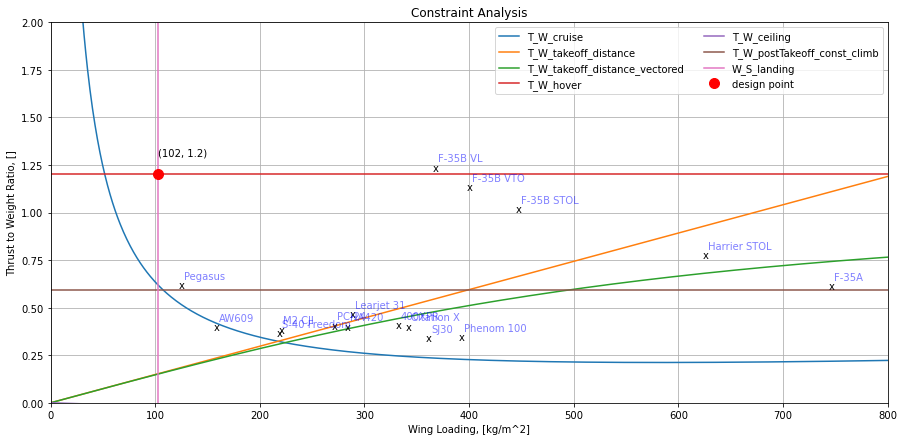

In [45]:
constraint_analysis(
    t_w_funcs=[T_W_cruise, T_W_takeoff_distance, T_W_takeoff_distance_vectored, T_W_hover, T_W_ceiling, T_W_postTakeoff_const_climb],
    w_s_funcs=[W_S_landing]
)